# Pytorch Image Classification

In [0]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import notebook
tqdm = notebook.tqdm
trange = notebook.trange
import torch
import torch.nn  as nn
import torch.nn.functional as F
import torch.optim as optim

## Data

Microsoft Dogs vs Cats Data

In [2]:
!mkdir /data
!wget -O /kaggle_data.zip "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
!unzip -q /kaggle_data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-03-30 22:03:04--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.53.252.195, 2600:1406:3400:78a::e59, 2600:1406:3400:797::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.53.252.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/kaggle_data.zip’

/kaggle_data.zip    100%[===================>] 786.68M  33.6MB/s    in 2m 22s  

2020-03-30 22:05:26 (5.54 MB/s) - ‘/kaggle_data.zip’ saved [824894548/824894548]

replace /data/PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /data/PetImages/Cat/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /data/PetImages/Cat/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
REBUILD_DATA = True

class DogsVsCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    
    training_data = []

    cat_count = 0
    dog_count = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            dir_path = f'/data/{label}/'
            for f in tqdm(os.listdir(dir_path)):
                try:    
                    img = cv2.imread(f'{dir_path}{f}', cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.cat_count += 1
                    elif label == self.DOGS:
                        self.dog_count += 1
                except Exception as e:
                    pass # bad images
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)

        print("CATS:", self.cat_count)
        print("DOGS:", self.dog_count)

if REBUILD_DATA:
    dogsvscats = DogsVsCats()
    dogsvscats.make_training_data()

PetImages/Cat



PetImages/Dog



CATS: 12476
DOGS: 12470


In [0]:
training_data = np.load("training_data.npy", allow_pickle=True)

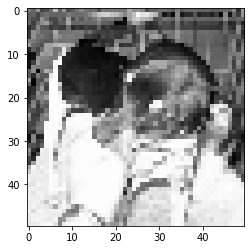

In [5]:
test_image = training_data[1][0]

plt.imshow(test_image, cmap="gray")
plt.show()

In [0]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1, 1, 50, 50) # 50 * 50 img
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        # print(x[0].shape)

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]

        return x
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.softmax(x, dim=1)


net = Net()

In [51]:
torch.cuda.is_available()

True

In [52]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print("On device:", device)
net.to(device)

On device: cuda:0


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

## Setup Data

In [53]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PERCENT = 0.1
val_size = int(len(X)*VAL_PERCENT)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


## Train

In [54]:
BATCH_SIZE = 100

EPOCHS = 10

for epoch in range(EPOCHS):
    for i in trange(0, len(train_X), BATCH_SIZE):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

print(loss)


tensor(0.0336, device='cuda:0', grad_fn=<MseLossBackward>)


## Test

In [56]:
correct = 0
total = 0
with torch.no_grad():
    for i in trange(len(test_X)):
        real_class = torch.argmax(test_y[i]).to(device)
        net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
        
print("Accuracy:", round(correct/total, 3))


Accuracy: 0.746
